In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import pydub
import os
import glob


In [2]:
class Clip:
    """A single 5-sec long recording."""
    
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    class Audio:
        """The actual audio data of the clip.
        
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage.
        """
        
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            # Actual recordings are sometimes not frame accurate, so we trim/overlay to exactly 5 seconds
            audio_segment = pydub.AudioSegment.from_file(self.path)
            audio_segment = audio_segment.set_frame_rate(Clip.RATE).set_channels(1).set_sample_width(2)
            audio_segment = audio_segment[:5000]  # Trim or overlay to exactly 5 seconds

            self.data = pydub.AudioSegment.silent(duration=5000).overlay(audio_segment)
            self.raw = (np.frombuffer(self.data.raw_data, dtype=np.int16) + 0.5) / (0x7FFF + 0.5)  # convert to float
            return self
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.data
            del self.raw
        
    def __init__(self, filename):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.directory = os.path.dirname(self.path)
        self.category = self.directory.split('/')[-1]
        
        self.audio = Clip.Audio(self.path)
        
        with self.audio as audio:
            self._compute_mfcc(audio)    
            self._compute_zcr(audio)

    # LEGACY CODE      
    # def _compute_mfcc(self, audio):
    #     # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
    #     self.melspectrogram = librosa.feature.melspectrogram(audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
    #     self.logamplitude = librosa.logamplitude(self.melspectrogram)
    #     self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()
    
    def _compute_mfcc(self, audio):
        # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
        self.melspectrogram = librosa.feature.melspectrogram(y=audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
        self.logamplitude = librosa.amplitude_to_db(self.melspectrogram, ref=np.max)
        self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()

            
    def _compute_zcr(self, audio):
        # Zero-crossing rate
        self.zcr = []
        frames = int(np.ceil(len(audio.data) / 1000.0 * Clip.RATE / Clip.FRAME))
        
        for i in range(0, frames):
            frame = Clip._get_frame(audio, i)
            self.zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))

        self.zcr = np.asarray(self.zcr)
            
    @classmethod
    def _get_frame(cls, audio, index):
        if index < 0:
            return None
        return audio.raw[(index * Clip.FRAME):(index+1) * Clip.FRAME]
    
    def __repr__(self):
        return '<{0}/{1}>'.format(self.category, self.filename)

In [3]:
import seaborn as sb
sb.set(style="white", palette="muted")

In [4]:
import random
random.seed(20150420)

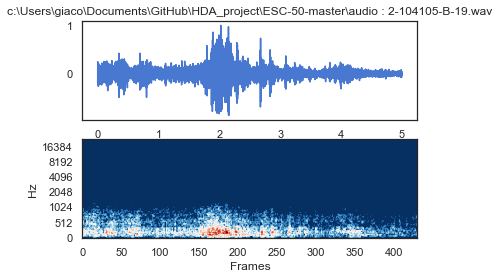

In [5]:
import IPython.display

# all_recordings = glob.glob('ESC-50-master/audio/*.wav')
# ESC-50-master\audio\2-104105-B-19.wav
all_recordings = glob.glob('ESC-50-master/audio/2-104105-B-19.wav')
clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])    

with clip.audio as audio:
    plt.subplot(2, 1, 1)
    plt.title('{0} : {1}'.format(clip.category, clip.filename))
    plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)
   
    plt.subplot(2, 1, 2)
    librosa.display.specshow(clip.logamplitude, sr=44100, x_axis='frames', y_axis='mel', cmap='RdBu_r')
    # change the height of the figure

# with clip.audio as audio:
#     plt.subplot(2, 1, 1)
#     plt.title('{0} : {1}'.format(clip.category, clip.filename))
#     plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)
   
#     plt.subplot(2, 1, 2)
#     librosa.display.specshow(clip.logamplitude, sr=44100, x_axis='frames', y_axis='mel', cmap='RdBu_r')
#     plt.colorbar(format="%+2.0f dB")
    
# plt.show()

IPython.display.Audio(filename=clip.path, rate=Clip.RATE)    


In [6]:
def load_dataset(name):
    """Load all dataset recordings into a nested list."""
    # TODO: since we know there are 50 categories and 10 classes for each category
    clips = [[] for i in range(5)]
    
    for clip in os.listdir(name):
      category_number = int(clip[0])
      category_index = category_number - 1
      clips[category_index].append(Clip('{0}/{1}'.format(name, clip)))
      print('All {0} recordings loaded.'.format(category_number))            

    IPython.display.clear_output()
    
    return clips

clips_50 = load_dataset('ESC-50-master/audio')


In [7]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]])

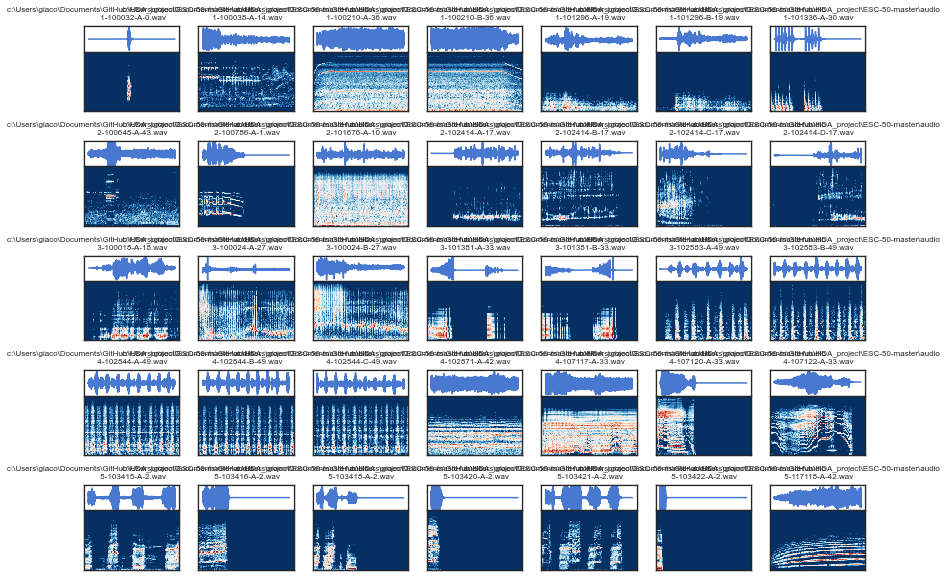

In [15]:
def plot_clip_overview(clip, ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    with clip.audio as audio:
        ax_waveform.plot(np.arange(0, len(audio.raw)) / float(Clip.RATE), audio.raw)
        ax_waveform.get_xaxis().set_visible(False)
        ax_waveform.get_yaxis().set_visible(False)
        ax_waveform.set_title('{0} \n {1}'.format(clip.category, clip.filename), {'fontsize': 8}, y=1.03)
        
        librosa.display.specshow(clip.logamplitude, sr=Clip.RATE, x_axis='time', y_axis='mel', cmap='RdBu_r')
        ax_spectrogram.get_xaxis().set_visible(False)
        ax_spectrogram.get_yaxis().set_visible(False)
        ax_spectrogram.set_facecolor('w')

categories = 5
clips_shown = 7
f, axes = plt.subplots(categories, clips_shown, figsize=(clips_shown * 2, categories * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for c in range(0, categories):
    for i in range(0, clips_shown):
        plot_clip_overview(clips_50[c][i], axes[c, i])


IndexError: list index out of range

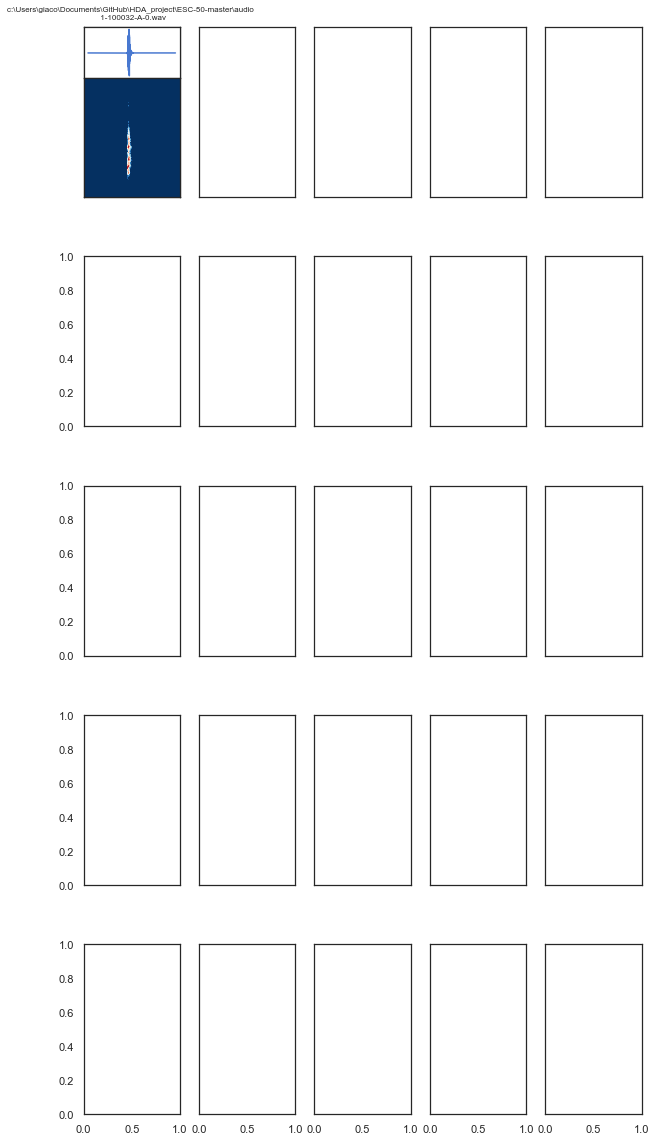

In [14]:
# Praticamente clips è un array da 50 arrays ciascuno dei quali contiene 10 clips
# in questo momento ho sbagliato e ho diviso nelle 5 categorie e non per classi

f, axes = plt.subplots(10, 5, figsize=(5 * 2, 10 * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for row in range(0, 10):
    for col in range(0, 5):
        plot_clip_overview(clips_50[col * 10 + row][0], axes[row, col])